<a href="https://www.kaggle.com/code/matthewanoshin/prediction-of-the-churn-of-clients?scriptVersionId=103224958" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Prediction of the Churn of clients

#### 1. Import all necessary libraries 



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

import optuna

#### 2. Read and prepare csv 

In [2]:
#read data
train_ = pd.read_csv("../input/advanced-dls-spring-2021/train.csv")
test_ = pd.read_csv("../input/advanced-dls-spring-2021/test.csv")

In [3]:
#show how does data look like
train_.head(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
5,25,19.80,475.2,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
6,27,90.15,2423.4,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,No,Bank transfer (automatic),0
7,1,45.70,45.7,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
9,72,61.20,4390.25,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0


In [4]:
#Numerical columns 
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

#Categorial columns
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [6]:
train_[num_cols].describe()

,ClientPeriod,MonthlySpending
count,5282.000000,5282.000000
mean,32.397009,64.924754
std,24.550326,30.176464
min,0.000000,18.250000
25%,9.000000,35.462500
50%,29.000000,70.400000
75%,55.000000,90.050000
max,72.000000,118.750000


In [7]:
#as i see, TotalSpent isnt numeric, so i will need to convert it
def Preprocess(data_):
    data_["TotalSpent"] = pd.to_numeric(data_["TotalSpent"], errors='coerce').fillna(0)
    return data_
Preprocess(train_)
Preprocess(test_)
None

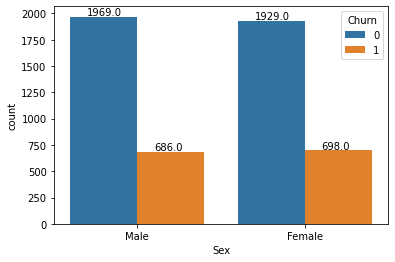

In [8]:
#visualization of Sex feature (in dependence with Churn)
ax = sns.countplot(x = "Sex", data = train_, hue = "Churn")
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x() + 0.1, p.get_height() + 15))

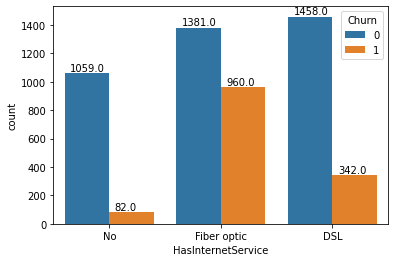

In [9]:
#visualization of HasInternetService feature (in dependence with Churn)
ax = sns.countplot(x = "HasInternetService", data = train_, hue = "Churn")
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x() + 0.05, p.get_height() + 15))

At least there's some correlation between *Fiber optics* and desire to quit company's service

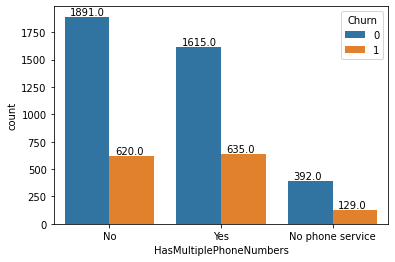

In [10]:
#vizualization of HasMultiplePhoneNumbers (in dependence with Churn)
ax = sns.countplot(x = "HasMultiplePhoneNumbers", data = train_, hue = "Churn")
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x() + 0.05, p.get_height() + 15))

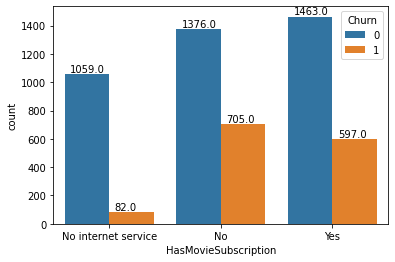

In [11]:
#vizualization of HasMovieSubscription (in dependence with Churn)
ax = sns.countplot(x = "HasMovieSubscription", data = train_, hue = "Churn")
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x() + 0.05, p.get_height() + 15))

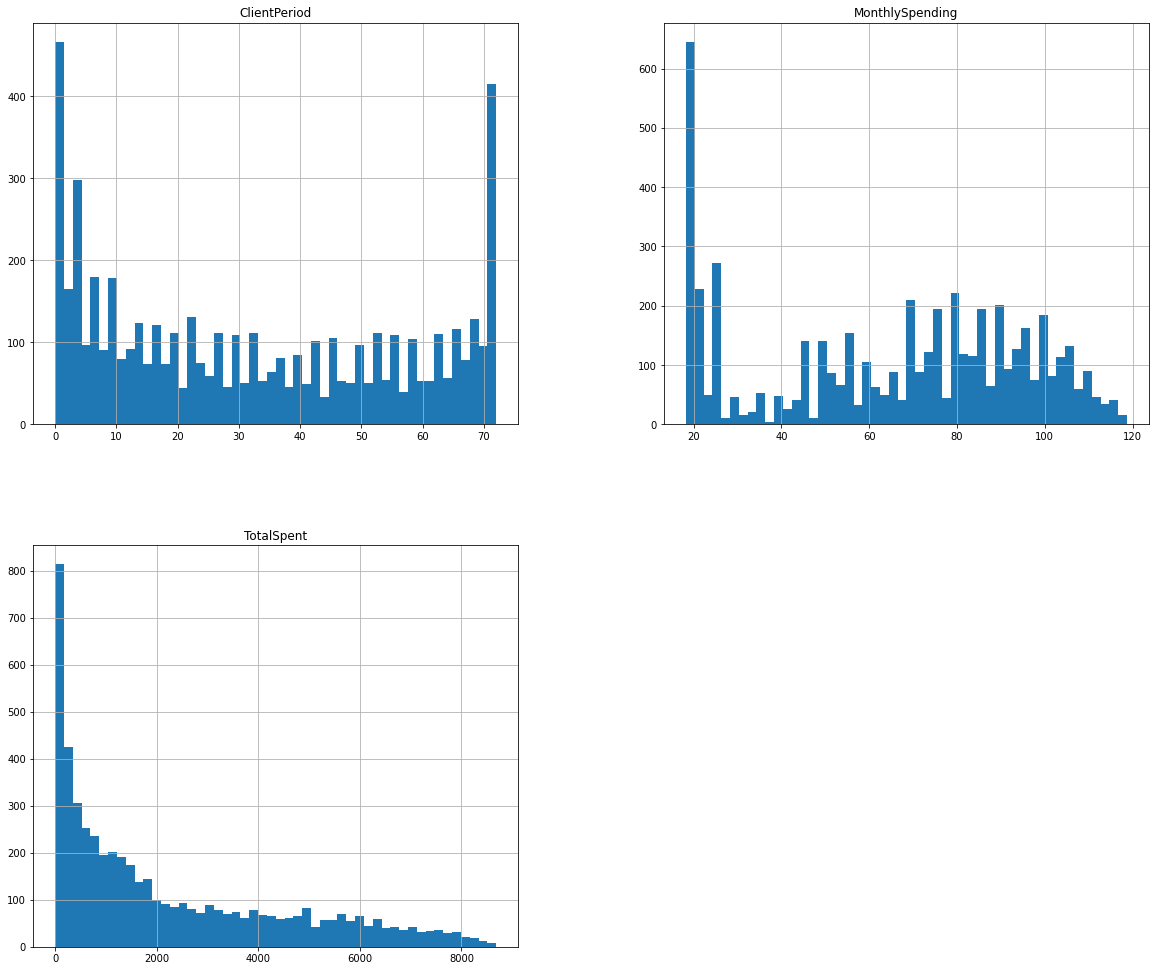

In [12]:
# The distribution of numerical features
train_[num_cols].hist(bins = 50, figsize = (20, 17))
None

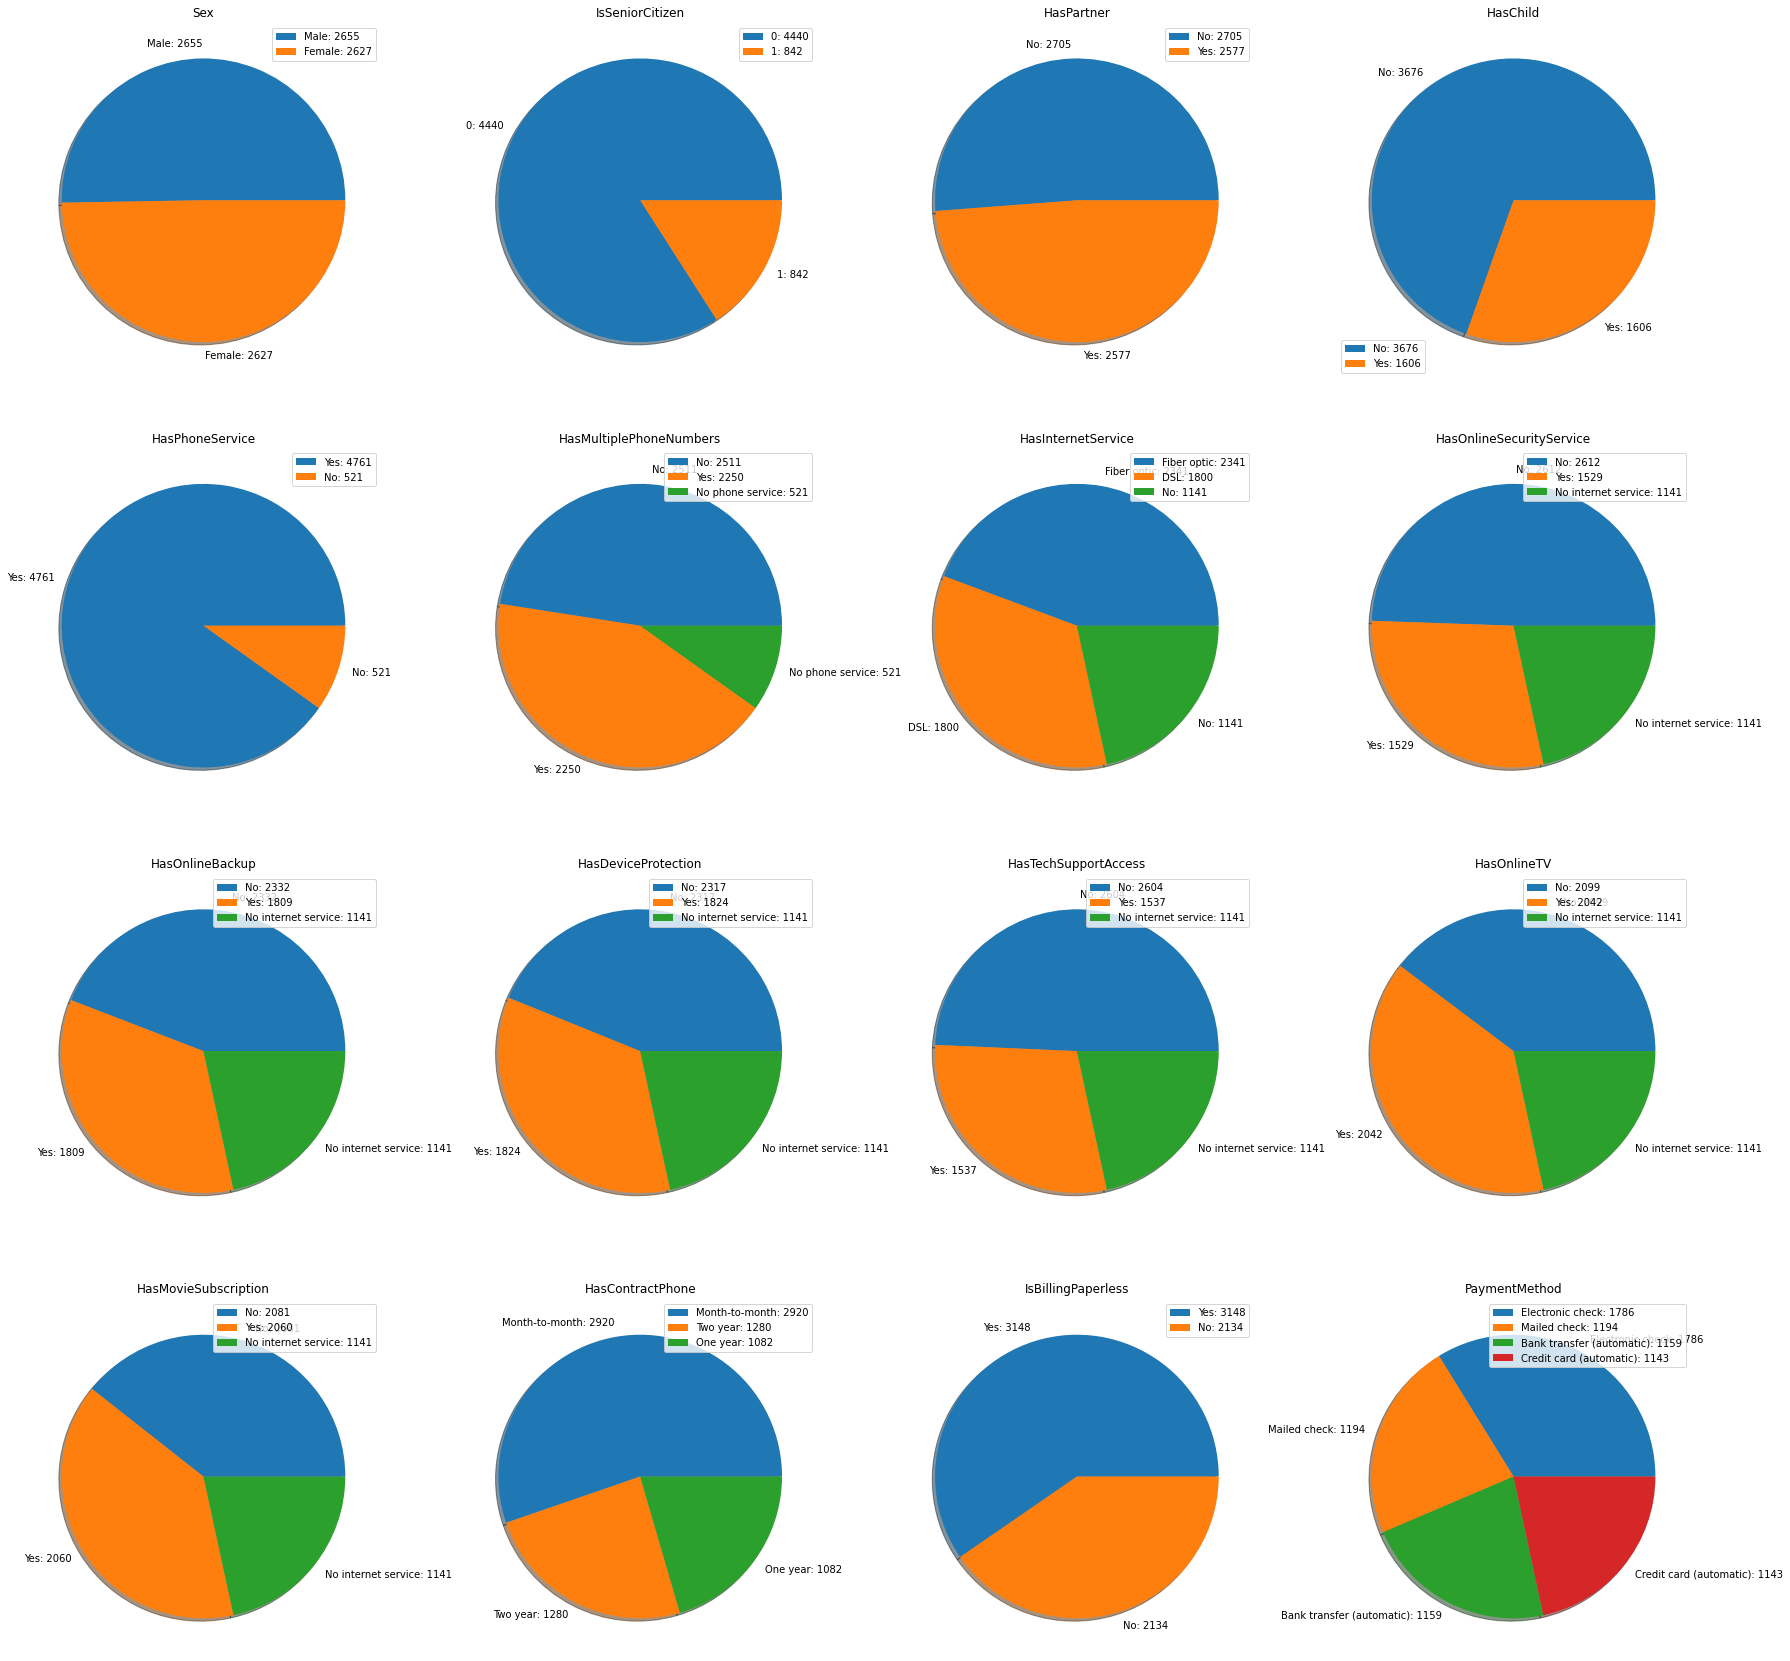

In [13]:
#visualization of categorical data 
#colors = ['wheat', 'cyan', 'springgreen', 'lightpink']
plt.figure(figsize = (30, 30))
for id, col in enumerate(cat_cols):
    ax = plt.subplot(4, 4, id + 1)
    plot_data = train_[col].value_counts().to_numpy()
    plot_labels = (train_[col].value_counts().index).astype(str) + ': ' + plot_data.astype(str)
    plt.pie(plot_data, labels = plot_labels, shadow = True)
    plt.title(col)
    plt.legend()

In [14]:
train_.Churn.value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

Data is really imbalanced ;(

#### 3. Learning 
In Learning i will use three different approachs:
1. Gradient Boosting via `CatBoost` library
2. Logistic Regression via `Sklearn` library
3. Random Forest via `Sklearn` library

After i will estimate their ROC-AUC and find best algorithm. Or implement stacking

In [15]:
X, y = train_[feature_cols], train_[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 3.1 Catboost:

In [16]:
classifier = CatBoostClassifier(verbose = False, cat_features = cat_cols)
classifier.fit(X_train, y_train)

In [17]:
prediction = classifier.predict_proba(X_test)
print(prediction)

[[0.4393811  0.5606189 ]
 [0.77763981 0.22236019]
 [0.73454608 0.26545392]
 ...
 [0.42507228 0.57492772]
 [0.99115135 0.00884865]
 [0.98960893 0.01039107]]


In [18]:
print("Best ROC-AUC is {0}".format(roc_auc_score(y_test, prediction[:, 1])))

Best ROC-AUC is 0.823387759625419


Obviously that's less than we would expect from `CatBoost`. Probably the reason is refitting 

In [19]:
''' uncoment this section on your personal computer. Kaggle inst capable of processing such big amounts of computations in normal period of time 
params = {
    'num_trees' : [],
    'lr' : [],
    'score_test' : []
}

num_trees = np.arange(50, 350, 50)
lr = np.arange(0.01, 0.51, 0.01)

for trees in num_trees:
    for rate in lr: 
        catboost_classifier = CatBoostClassifier(cat_features = cat_cols, 
                                                verbose = False, 
                                                n_estimators = trees, 
                                                learning_rate = rate)
            
        catboost_classifier.fit(X_train, y_train)
        prediction = classifier.predict_proba(X_test)

        params['num_trees'].append(trees)
        params['lr'].append(rate)
        params['score_test'].append(roc_auc_score(y_test, prediction[:, 1]))

display(pd.DataFrame(params).sort_values('score_test').head(10))
'''

" uncoment this section on your personal computer. Kaggle inst capable of processing such big amounts of computations in normal period of time \nparams = {\n    'num_trees' : [],\n    'lr' : [],\n    'score_test' : []\n}\n\nnum_trees = np.arange(50, 350, 50)\nlr = np.arange(0.01, 0.51, 0.01)\n\nfor trees in num_trees:\n    for rate in lr: \n        catboost_classifier = CatBoostClassifier(cat_features = cat_cols, \n                                                verbose = False, \n                                                n_estimators = trees, \n                                                learning_rate = rate)\n            \n        catboost_classifier.fit(X_train, y_train)\n        prediction = classifier.predict_proba(X_test)\n\n        params['num_trees'].append(trees)\n        params['lr'].append(rate)\n        params['score_test'].append(roc_auc_score(y_test, prediction[:, 1]))\n\ndisplay(pd.DataFrame(params).sort_values('score_test').head(10))\n"

Still not the score that expected to get

In [20]:
catboost_estimator = CatBoostClassifier(learning_rate = 0.01, n_estimators = 200, cat_features = cat_cols, verbose = False)
catboost_estimator .fit(X_train, y_train)
prediction = catboost_estimator.predict_proba(X_test)

In [21]:
fpr_catboost, tpr_catboost, thresholds  = roc_curve(y_test, prediction[:, 1])

#### 3.2 Logistic Regression:
Let's create pipeline consisted of scaleres and regression in the end 

In [22]:
ct = ColumnTransformer(
    [("num", make_pipeline(StandardScaler(), MinMaxScaler()), num_cols),
    ("col", OneHotEncoder(), cat_cols)]
)

pipeline__ = make_pipeline(ct, LogisticRegression(max_iter = 500))


In [23]:
gs = GridSearchCV(pipeline__, param_grid = {"logisticregression__C": [100, 10, 1, 0.1, 0.01, 0.001]}, scoring = 'roc_auc', refit = True)

In [24]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('col',
                                                                         O

In [25]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.111343,0.008841,0.019311,0.000187,100,{'logisticregression__C': 100},0.829838,0.836161,0.854718,0.862905,0.860321,0.848789,0.013311,1
1,0.106066,0.006518,0.019021,0.000260,10,{'logisticregression__C': 10},0.829657,0.835211,0.855726,0.861933,0.860342,0.848574,0.013450,2
2,0.185473,0.070332,0.023194,0.007434,1,{'logisticregression__C': 1},0.827590,0.833290,0.854776,0.860693,0.861101,0.847490,0.014215,3
3,0.129542,0.041124,0.025046,0.007885,0.1,{'logisticregression__C': 0.1},0.823711,0.833029,0.851977,0.859598,0.860841,0.845831,0.014872,4
4,0.078643,0.010160,0.019523,0.000434,0.01,{'logisticregression__C': 0.01},0.814501,0.827489,0.845146,0.852405,0.856763,0.839261,0.015908,5
5,0.060145,0.000541,0.019089,0.000134,0.001,{'logisticregression__C': 0.001},0.803994,0.814791,0.837546,0.842166,0.848145,0.829328,0.016968,6


In [26]:
print("Best ROC-AUC is {0} with C equals {1}".format(round(gs.best_score_, 3), gs.best_params_['logisticregression__C']))

Best ROC-AUC is 0.849 with C equals 100


In [27]:
prediction = gs.best_estimator_.predict_proba(X_test)

In [28]:
fpr_logistic, tpr_logistic, thresholds  = roc_curve(y_test, prediction[:, 1])

#### 3.3 Random Forest Classifier

In [29]:
ct = ColumnTransformer(
    [("num", make_pipeline(StandardScaler(), MinMaxScaler()), num_cols),
    ("col", OneHotEncoder(), cat_cols)]
)

pipeline__ = make_pipeline(ct, RandomForestClassifier())

pipeline__.fit(X_train, y_train)
prediction = pipeline__.predict_proba(X_test)

In [30]:
fpr_forest, tpr_forest, thresholds  = roc_curve(y_test, prediction[:, 1])

##### 3.4 ROC-AUC

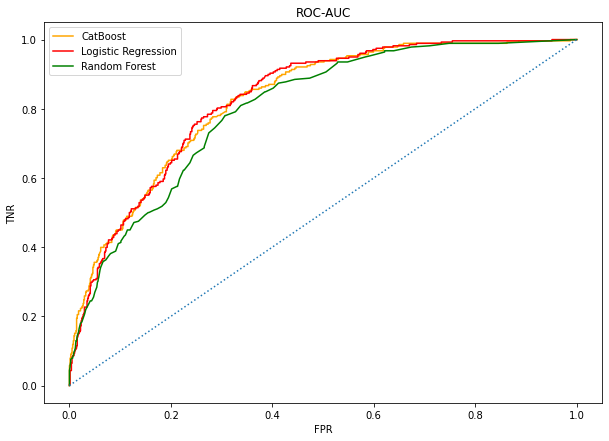

In [31]:
plt.figure(figsize = (10, 7))
plt.title("ROC-AUC")
plt.plot(fpr_catboost, tpr_catboost, c = 'orange', label = 'CatBoost')
plt.plot(fpr_logistic, tpr_logistic, c = 'red', label = 'Logistic Regression')
plt.plot(fpr_forest, tpr_forest, c = 'green', label = 'Random Forest')
plt.plot([0,1], [0, 1], linestyle = ':')
plt.xlabel("FPR")
plt.ylabel("TNR")
plt.legend()
plt.show()

It seems like the best algorithm is `Logistic Regression.` But `CatBoost` is so near, that i rather prefer to make a stack of `CatBoost` and `Logistic Regression` if it needed 

#### 4. Creating the submit csv

In [32]:
final_pred = gs.best_estimator_.predict_proba(test_)[:, 1]

In [33]:
submission_ = pd.read_csv('../input/advanced-dls-spring-2021/submission.csv')

In [34]:
submission_['Churn'] = final_pred

In [35]:
submission_.head(25)

,Id,Churn
0,0,0.038074
1,1,0.749419
2,2,0.681174
3,3,0.005875
4,4,0.001080
5,5,0.133578
6,6,0.530690
7,7,0.336858
8,8,0.070604
9,9,0.425236


In [36]:
submission_.to_csv("/kaggle/working/submission.csv", index = False)